# Sorting

Training a one-layer transformer to sort fixed-length lists. Problem idea from [200 Open Problems](https://docs.google.com/document/d/1WONBzNqfKIxERejrrPlQMyKqg7jSFW92x5UMXNrMdPo/edit#heading=h.n514s7caro7u). Based on [Neel's video](https://www.youtube.com/watch?v=yo4QvDn-vsU) and accompanying [colab notebook](https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/no-position-experiment/No_Position_Experiment.ipynb#scrollTo=lymHglrXGrFC).

## [ParenTransformer](https://github.com/pranavgade20/wmlb/blob/master/w2d3_instructions.md) Notes

- Positional embeddings are sinusoidal (non-learned).
- Bidirectional attention
- Square MLP layers
- Final Layer Norm
- no dropout
- [BEGIN] and [END] tokens

In [12]:
import random
from typing import Tuple

import circuitsvis as cv
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import transformer_lens
import transformer_lens.utils as utils
from fancy_einsum import einsum
from torch.utils.data import DataLoader, Dataset
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
)
from transformer_lens.hook_points import (  # Hooking utilities
    HookedRootModule,
    HookPoint,
)

from torchtyping import TensorType as TT, patch_typeguard
from typeguard import typechecked

patch_typeguard()  # use before @typechecked


def total_params(model: nn.Module):
    """
    ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(DEVICE) -> 58634
    """
    
    return sum([param.numel() for name, param in model.named_parameters()])

In [13]:
device = "cuda"

## Model

In [62]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Config:
    d_model: int = 56
    num_heads: int = 1
    n_layers: int = 1
    seq_len: int = 10
    distinct_nums: int = 10
    normalization: Optional[str] = None

    def __post_init__(self):
        assert self.d_model % self.num_heads == 0

In [63]:
def make_transformer(cfg: Config) -> HookedTransformer:
    """
    seq_len: length of sequence to be sorted. input will be of form [BOS] ... unsorted sequence [MID] ... sorted sequence
    distinct_nums: number of distinct tokens that can appear in sequence (excluding [BOS] and [MID])
    """
    transformer_cfg = HookedTransformerConfig(
        n_layers=cfg.n_layers,
        d_model=cfg.d_model,
        d_head=cfg.d_model // cfg.num_heads,
        n_ctx=2 * (cfg.seq_len + 1),
        act_fn='relu',
        d_vocab=cfg.distinct_nums+2,
        normalization_type=cfg.normalization,
        attn_only=True
    )
    model = HookedTransformer(transformer_cfg)
    return model

In [64]:
cfg = Config()
model = make_transformer(cfg)
print(total_params(model))

15356


In [65]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [66]:
for name, param in model.named_parameters():
    print(name, param.numel())

embed.W_E 672
pos_embed.W_pos 1232
blocks.0.attn.W_Q 3136
blocks.0.attn.W_K 3136
blocks.0.attn.W_V 3136
blocks.0.attn.W_O 3136
blocks.0.attn.b_Q 56
blocks.0.attn.b_K 56
blocks.0.attn.b_V 56
blocks.0.attn.b_O 56
unembed.W_U 672
unembed.b_U 12


## Data + Loss

In [22]:
def gen_data(batch_size: int, cfg: Config, gen_random: bool=False):
    BOS, MOS = cfg.distinct_nums, cfg.distinct_nums+1
    data = t.zeros((batch_size, 2*cfg.seq_len + 2), dtype=t.long)

    if not gen_random:
        unsorted_seqs=[]
        for _ in range(batch_size):
            good=[]
            while good==[]:
                p=random.random()
                good=[t for t in range(cfg.distinct_nums) if random.random()>p]
            if random.random()<1/3.:
                low=random.randint(0,cfg.distinct_nums-1)
                high=random.randint(0,cfg.distinct_nums-1)
                if low>high: low,high=high,low
                good=list(range(low,high+1))
            good=t.tensor(good,dtype=t.long)
            # unsorted_seqs=(good[t.randint(0, good.shape[0], (batch_size, cfg.seq_len,))])
            unsorted_seqs.append(good[t.randint(0, good.shape[0], (cfg.seq_len,))])
        unsorted_seqs = t.stack(unsorted_seqs,dim=0)
    else:
        unsorted_seqs = t.randint(0, cfg.distinct_nums, (batch_size, cfg.seq_len))

    sorted_seqs = t.sort(unsorted_seqs, dim=-1).values

    data[:, 0] = BOS
    data[:, 1:cfg.seq_len+1] = unsorted_seqs
    data[:, cfg.seq_len+1] = MOS
    data[:, cfg.seq_len+2:] = sorted_seqs
    return data

sample_data = gen_data(8, Config(seq_len=10, distinct_nums=10))
print(sample_data)
print(sample_data.dtype)

tensor([[10,  7,  8,  9,  9,  8,  9,  7,  9,  8,  8, 11,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9],
        [10,  1,  9,  0,  5,  6,  2,  6,  4,  4,  0, 11,  0,  0,  1,  2,  4,  4,
          5,  6,  6,  9],
        [10,  5,  1,  5,  1,  1,  1,  5,  1,  5,  5, 11,  1,  1,  1,  1,  1,  5,
          5,  5,  5,  5],
        [10,  7,  9,  7,  9,  3,  4,  3,  9,  7,  3, 11,  3,  3,  3,  4,  7,  7,
          7,  9,  9,  9],
        [10,  2,  4,  3,  9,  3,  7,  6,  7,  0,  3, 11,  0,  2,  3,  3,  3,  4,
          6,  7,  7,  9],
        [10,  8,  6,  0,  6,  8,  0,  4,  0,  0,  8, 11,  0,  0,  0,  0,  4,  6,
          6,  8,  8,  8],
        [10,  0,  3,  1,  0,  4,  3,  5,  3,  5,  7, 11,  0,  0,  1,  3,  3,  3,
          4,  5,  5,  7],
        [10,  9,  5,  0,  0,  4,  5,  1,  6,  8,  0, 11,  0,  0,  0,  1,  4,  5,
          5,  6,  8,  9]])
torch.int64


In [23]:
@typechecked
def loss_fn(logits: TT["b", "s", "v"], inputs: TT["b", "s"]):
    """logits: unnormalized"""
    seq_len = logits.shape[1] // 2 - 1
    preds = logits[:, seq_len+1:-1].transpose(1, 2) # b, v, s
    targets = inputs[:, seq_len+2:] # b, s
    return F.cross_entropy(preds, targets)

inputs = t.tensor([[3, 2, 1, 4, 1, 2]])
logits = t.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # log(5)
logits = t.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 100, 0, 0, 0],
    [0, 0, 100, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # 0, correct order
logits = t.tensor([[
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 100, 0, 0],
    [0, 100, 0, 0, 0],
    [0, 0, 0, 0, 0],
]]).float()
print(loss_fn(logits, inputs)) # 100, wrong order

tensor(1.6094)
tensor(0.)
tensor(100.)


## Training

In [72]:
model = make_transformer(cfg)

In [73]:
def train(cfg: Config, batch_size: int=1024, lr: float=1e-3, wd:float = 1e-4,num_epochs: int=5000):
    """TODO: adjust parameters?"""
    model.train()

    opt = t.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # TODO: weight decay?
    def make_dataloader():
        while True:
            yield gen_data(batch_size, cfg)
    dataloader = make_dataloader()
    
    losses = []
    for epoch in range(num_epochs):
        opt.zero_grad()
        tokens = next(dataloader).to(device)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {loss.item()}',flush=True)

train(cfg)

Epoch 0: 2.4606099128723145
Epoch 100: 0.7521477341651917
Epoch 200: 0.35208624601364136
Epoch 300: 0.2567881941795349
Epoch 400: 0.19820085167884827
Epoch 500: 0.13043227791786194
Epoch 600: 0.08483508229255676
Epoch 700: 0.0652446523308754
Epoch 800: 0.04878987371921539
Epoch 900: 0.04220093786716461
Epoch 1000: 0.03811906278133392


KeyboardInterrupt: 

Note: 1 head transformer stagnates at 0.03 loss.

In [76]:
MODEL_PATH = "model_fixedlength_causal_normal.pt"

# import os

if os.path.exists(MODEL_PATH):
    model = t.load(MODEL_PATH)
    print("Loaded Model")
else:
    train(cfg)
# t.save(model, MODEL_PATH)
print("Saved Model")

Loaded Model
Saved Model


In [77]:
# print # of parameters
print(total_params(model))

15356


In [78]:
model.cfg

HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'causal',
 'attn_only': True,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 56,
 'd_mlp': None,
 'd_model': 56,
 'd_vocab': 12,
 'd_vocab_out': 12,
 'device': 'cuda',
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.10690449676496976,
 'model_name': 'custom',
 'n_ctx': 22,
 'n_heads': 1,
 'n_layers': 1,
 'n_params': 12544,
 'normalization_type': None,
 'original_architecture': None,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': None,
 'tokenizer_name': None,
 'use_attn_result': False,
 'use_attn_scale': True,
 'use_local_attn': False,
 'window_size': None}

In [79]:
def evaluate(cfg: Config, model: HookedTransformer, batch_size: int):
    model.eval()
    with t.inference_mode():
        tokens = gen_data(batch_size, cfg).to(device)
        logits = model(tokens)
        return loss_fn(logits, tokens)

In [80]:
evaluate(cfg, model, 4000)

tensor(0.0136, device='cuda:0')

## Interpretability

In [96]:
from typing import List
import seaborn as sns


def gen_example_from(cfg: Config, seq: List[int]) -> t.Tensor:
    BOS,MOS = cfg.seq_len,cfg.seq_len+1
    return t.tensor([BOS] + seq + [MOS] + sorted(seq))

def heatmap(logprobs: t.Tensor, ax=None):
    sns.heatmap(t.clip(logprobs-t.amax(logprobs,dim=-1,keepdim=True),-99.,99.).cpu(),annot=True,ax=ax)

def heatmap2(logprobs: t.Tensor, ax=None):
    sns.heatmap(t.clip(logprobs-t.amax(logprobs,dim=-1,keepdim=True),-99.,99.).cpu(),annot=True,ax=ax,fmt=".2g")

@typechecked
def visualize_output(cfg: Config, sample_data: TT["s"]):
    assert sample_data.numel() == 2 * cfg.seq_len + 2
    with t.inference_mode():
        logprobs = model(sample_data.unsqueeze(0))[0, cfg.seq_len+1:-1]
        plt.title("Output: Log Probabilities")
        plt.title(f"Output: Logits For {list([x.item() for x in sample_data[:cfg.seq_len+1] if x < cfg.distinct_nums])}")
        heatmap2(logprobs)
        plt.show()
        plt.title("Output: Probabilities")
        probs = logprobs.softmax(dim=-1)
        plt.imshow(probs.cpu())
        plt.ylabel("position")
        plt.xlabel("value")
        plt.colorbar()
        plt.show()

@typechecked
def visualize_output_by_input_pos(cfg: Config, sample_data: TT["s"], dest: int):
    """plot logits for each source, weighted by attention"""
    with t.inference_mode():
        out, cache = model.run_with_cache(sample_data.unsqueeze(0))
        # cache: dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post'])
        
        # cache["resid_post", 0]: 1 x 22 x 25
        tot_out = cache["resid_post", 0][0, dest] @ model.W_U # 22
        attn_dest = cache["pattern", 0, "attn"][0, 0, dest]

        rows = [cache["resid_pre", 0][0, dest] @ model.W_U]
        labels = ["embed"]
        for i in range(attn_dest.shape[0]):
            tmp = ((cache["resid_pre", 0][0, i] @ model.W_V[0, 0] + model.b_V) @ model.W_O[0, 0]).squeeze()
            rows.append(attn_dest[i] * tmp @ model.W_U)
            labels.append(f"inp_{i}")

        rows.append((model.b_O @ model.W_U).squeeze())
        
        rows = t.stack(rows)
        rows -= rows.mean(dim=-1, keepdim=True)
        print("Expected", tot_out - tot_out.mean())
        print("Got", t.sum(rows, dim=0) - t.sum(rows, dim=0).mean())
        
        plt.figure()
        plt.imshow(rows.cpu())
        plt.colorbar()

def item_to_string(cfg: Config, x: t.Tensor):
    i = x.item()
    if i < cfg.distinct_nums:
        return str(i)
    if i == cfg.distinct_nums:
        return "BOS"
    return "MOS"


In [97]:

@typechecked
def visualize_attention(cfg: Config, sample_data: TT["s"]):
    assert sample_data.numel() == 2 * cfg.seq_len + 2
    with t.inference_mode():
        _, cache = model.run_with_cache(sample_data.unsqueeze(0))
        attention_pattern = cache["pattern", 0, "attn"]
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data], attention=attention_pattern.squeeze(0))
        with open("layer0_attn_patterns.html", "w") as f:
            f.write(str(html))
        return html

def visualize_output_and_attention(cfg, sample_data: TT["s"]):
    print("unsorted_sequence", sample_data[1:cfg.seq_len+1])
    print("sorted_sequence", sample_data[cfg.seq_len+2:])
    visualize_output(cfg, sample_data)
    return visualize_attention(cfg, sample_data)


def visualize_attention_many(cfg, sample_data):
    with t.inference_mode():
        _, cache = model.run_with_cache(sample_data)
        attention_pattern = t.mean(cache["pattern", 0, "attn"],dim=0)
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        return html

In [83]:
# 0: BOS
# 11: MOS
# 12...16: 0
# 17...21: 1

### Average Attention

On average, attention is distributed equally among the input sequence. Attention is also paid to the BOS token.

In [84]:
visualize_attention_many(cfg, gen_data(1000, cfg))

### Examples

In [86]:
def evaluate_diff(cfg: Config, model: HookedTransformer, batch_size: int):
    model.eval()
    with t.inference_mode():
        tokens = gen_data(batch_size, cfg, gen_random=False).to(device)
        logits = model(tokens)
        output = logits.argmax(dim=-1)
        diff_pos = (output[:, cfg.seq_len+1:-1] != tokens[:, cfg.seq_len+2:])
        wrong=0
        for aa,tt,oo in zip(tokens.squeeze(),diff_pos.squeeze(),output.squeeze()):
            if any(tt.tolist()):
                print('Input',aa.tolist())
                print('Out',oo.tolist()[cfg.seq_len+1:-1])
        print('acc',1-wrong/batch_size)

evaluate_diff(cfg, model, 3000)

Input [10, 1, 9, 9, 9, 1, 9, 1, 1, 9, 1, 11, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9]
Out [1, 1, 1, 1, 1, 8, 9, 9, 9, 9]
Input [10, 9, 9, 8, 7, 8, 9, 9, 8, 8, 7, 11, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9]
Out [7, 7, 8, 8, 8, 8, 8, 9, 9, 9]
Input [10, 9, 8, 3, 9, 3, 9, 3, 0, 8, 9, 11, 0, 3, 3, 3, 8, 8, 9, 9, 9, 9]
Out [0, 3, 3, 3, 8, 9, 9, 9, 9, 9]
Input [10, 4, 4, 0, 9, 8, 9, 1, 8, 1, 9, 11, 0, 1, 1, 4, 4, 8, 8, 9, 9, 9]
Out [0, 1, 1, 4, 4, 8, 9, 9, 9, 9]
Input [10, 9, 8, 7, 3, 8, 4, 8, 8, 9, 3, 11, 3, 3, 4, 7, 8, 8, 8, 8, 9, 9]
Out [3, 3, 4, 7, 8, 8, 8, 8, 8, 9]
Input [10, 8, 8, 8, 8, 9, 9, 8, 8, 8, 9, 11, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9]
Out [8, 8, 8, 8, 8, 8, 8, 8, 9, 9]
Input [10, 9, 7, 8, 9, 7, 8, 8, 8, 8, 8, 11, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9]
Out [7, 7, 8, 8, 8, 8, 8, 8, 8, 9]
Input [10, 9, 8, 8, 9, 9, 8, 9, 9, 5, 5, 11, 5, 5, 8, 8, 8, 9, 9, 9, 9, 9]
Out [5, 5, 8, 9, 9, 9, 9, 9, 9, 9]
Input [10, 9, 8, 8, 7, 9, 7, 9, 8, 7, 8, 11, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9]
Out [7, 7, 7, 8, 8, 8, 8, 8, 9, 9]
Input [10,

#### Random

In [74]:
def plot_qk_for_out0(poss):
    """Pos: position you are trying to predict"""
    fig, ax = plt.subplots(1,2,figsize=(13, 7))
    with t.inference_mode():
        for ix,pos in enumerate(poss):
            embeds = model.W_E.clone()
            if pos is not None:
                embeds += model.W_pos[11 + pos] # 11 is MOS
            head=0
            QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ ((model.W_E + model.W_pos[1]) @ model.W_K[0, head] + model.b_K[0, head]).T
            ax[ix].set_title(f"QK For Query Position {pos} Head {head}")
            QK = QK[:15, :15]
            heatmap(QK.cpu(), ax=ax[ix])
            ax[ix].set_ylabel("Query Token")
            ax[ix].set_xlabel("Key Token")
            plt.tight_layout()

# def compute_logits(example, pos_at):
#     with t.inference_mode():
#         out, cache = model.run_with_cache(example)
#         embeds = model.W_E[example].squeeze()
#         max_dif(embeds, cache['embed'].squeeze())
#         pos_embeds = model.W_pos[t.arange(example.shape[0])].squeeze()
#         max_dif(pos_embeds, cache['pos_embed'].squeeze())
#         resids = embeds + pos_embeds
#         Q = resids @ model.W_Q[0, 0] + model.b_Q[0, 0]
#         K = resids @ model.W_K[0, 0] + model.b_K[0, 0]
#         print(Q[0])
#         print(cache['q', 0, 0].squeeze()[0])
#         assert False
#         row = (Q @ K.T)[pos_at]
#         row[pos_at:] = -10000
#         row -= row.max()
#         print(t.exp(row))
#         # print(Q.shape, K.shape)

# compute_logits(gen_example_from(cfg, [0]+[2]+[7]*8), 12)

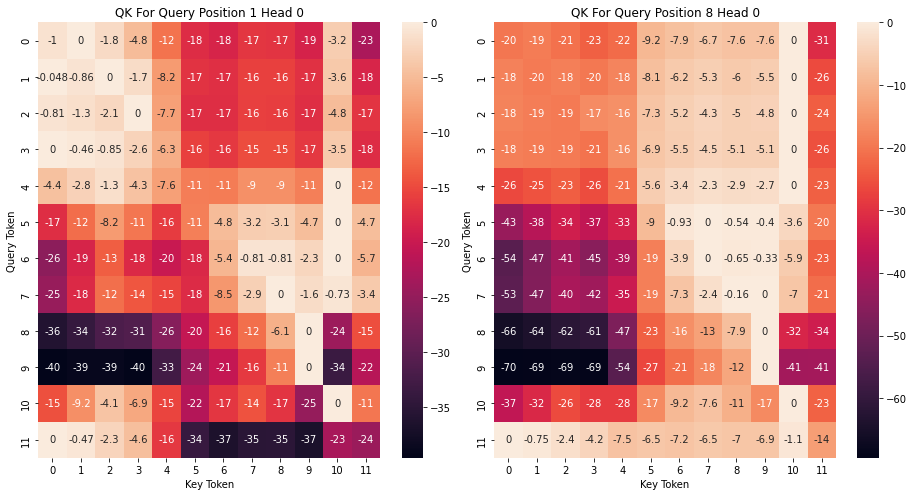

In [75]:
plot_qk_for_out0([1,8])

unsorted_sequence tensor([8, 8, 8, 8, 8, 9, 9, 9, 9, 8])
sorted_sequence tensor([8, 8, 8, 8, 8, 8, 9, 9, 9, 9])


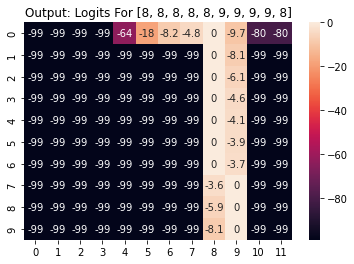

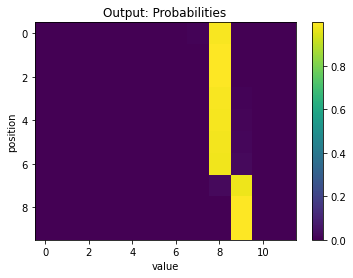

In [102]:
#plt.figure(figsize=(10/1.5,7/1.5))
visualize_output_and_attention(cfg, gen_example_from(cfg, [8, 8, 8, 8, 8, 9, 9, 9, 9, 8]))

#### Random Permutation

unsorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


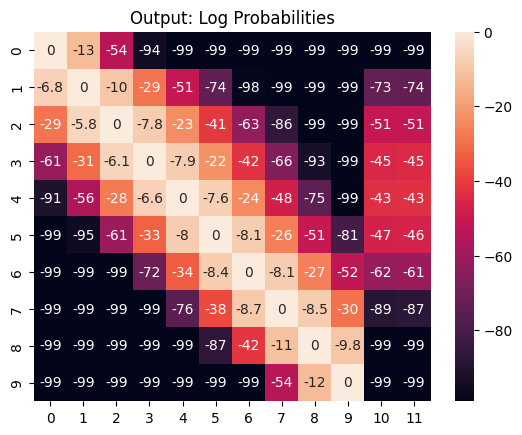

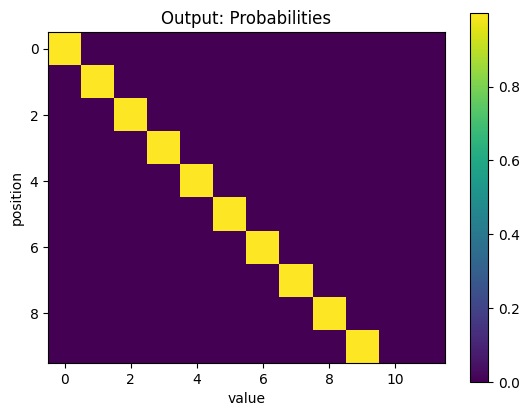

In [81]:
# import random

inp = list(range(10))
# random.shuffle(inp)
example = gen_example_from(cfg, inp)

visualize_output_and_attention(cfg, example)

### Adversarial

In [82]:
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 15)
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 16)
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [3] + [7]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*6 + [7]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0] + [1]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*5 + [7]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,8,8,8,8,8,8,8,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,0,0,0,0,0,0,0,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,5,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,1,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*9+[1]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*1+[0]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*6+[0]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*6))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*1+[1]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [2]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[5]+[6]+[9]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8,9,9]+[0]*7))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*9+[0]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]*5+[5]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*8+[9]*2))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*10))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[8]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[9]*9))

## Logit Attributions

torch.Size([2, 1000, 22, 56])
torch.Size([2, 22, 12])
torch.Size([2, 22, 12])


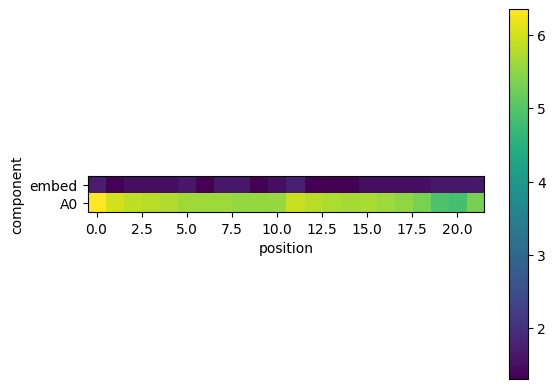

In [83]:
def visualize_logit_attributions_many(cfg: Config, sample_data):
    with t.inference_mode():
        out, cache = model.run_with_cache(sample_data)
        resid_components = [cache["embed"], cache["attn_out", 0]]

        labels = ["embed", "A0"]
        resid_stack = torch.stack(resid_components, 0)
        resid_stack = resid_stack - resid_stack.mean(-1, keepdim=True)
        print(resid_stack.shape)

        batch_index = 0
        logit_components = resid_stack[:, batch_index] @ model.W_U
        print(logit_components.shape)

        logit_components = logit_components - logit_components.mean(-1, keepdim=True)
        print(logit_components.shape)

        plt.imshow(t.log(t.linalg.norm(logit_components, dim=-1).cpu()))
        
        plt.yticks(range(len(labels)), labels)
        plt.ylabel("component")
        plt.xlabel("position")
        plt.colorbar()
        # line(logit_components[:, torch.arange(1, model.cfg.n_ctx).cuda(), tokens[:-1]].T, line_labels=labels)
        # print(cache)
        # print(cache["embed"].shape)
        # print(cache["attn_out", 0].shape)
        # print(cache["mlp_out", 0].shape)

        # print((cache["embed"][0,0] + cache["attn_out", 0][0,0] + cache["mlp_out", 0][0,0]) @ model.W_U)
        # print(out[0, 0])

        # print(model.W_U.shape)
        # model.W_U @ 
        # print(out.shape, out[0])
        # resid_components = [cache["embed"], cache["attn_out", 0], cache["mlp_out", 0], cache["attn_out", 1], cache["mlp_out", 1]]
        # attention_pattern = t.mean(cache["pattern", 0, "attn"],dim=0)
        # html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        # return html
    
visualize_logit_attributions_many(cfg, gen_data(1000, cfg))

### Attn 0

#### QK (Position)

As expected, for a fixed query position, it pays approximately equal attention to the keys correpsonding to positions 1 through 10.

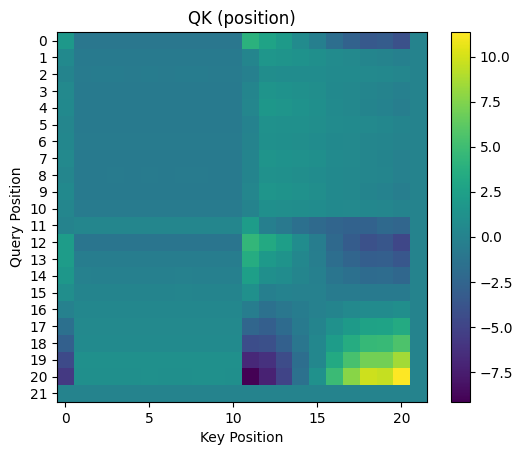

In [84]:
with t.inference_mode():
    QK = model.W_pos @ model.W_Q[0, 0] @ model.W_K[0, 0].T @ model.W_pos.T
    plt.title("QK (position)")
    plt.imshow(QK.cpu())
    plt.colorbar()
    plt.ylabel("Query Position")
    plt.xlabel("Key Position")
    plt.yticks(range(QK.shape[0]))

In [122]:
def plot_qk_for_out(pos: Optional[int] = None):
    """Pos: position you are trying to predict"""
    print("pos =", pos)
    with t.inference_mode():
        embeds = model.W_E.clone()
        if pos is not None:
            embeds += model.W_pos[11 + pos] # 11 is MOS
        fig, ax = plt.subplots(1,2,figsize=(12.8, 4.8))
        for head in range(2):
            QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (model.W_E @ model.W_K[0, head] + model.b_K[0, head]).T
            ax[head].set_title(f"QK For Position {pos} Head {head}")
            QK = QK[:10, :10]
            heatmap(QK.cpu(), ax=ax[head])
            ax[head].set_ylabel("Query Value")
            ax[head].set_xlabel("Key Value")
        plt.tight_layout()

# def compute_logits(example, pos_at):
#     with t.inference_mode():
#         out, cache = model.run_with_cache(example)
#         embeds = model.W_E[example].squeeze()
#         max_dif(embeds, cache['embed'].squeeze())
#         pos_embeds = model.W_pos[t.arange(example.shape[0])].squeeze()
#         max_dif(pos_embeds, cache['pos_embed'].squeeze())
#         resids = embeds + pos_embeds
#         Q = resids @ model.W_Q[0, 0] + model.b_Q[0, 0]
#         K = resids @ model.W_K[0, 0] + model.b_K[0, 0]
#         print(Q[0])
#         print(cache['q', 0, 0].squeeze()[0])
#         assert False
#         row = (Q @ K.T)[pos_at]
#         row[pos_at:] = -10000
#         row -= row.max()
#         print(t.exp(row))
#         # print(Q.shape, K.shape)

# compute_logits(gen_example_from(cfg, [0]+[2]+[7]*8), 12)

pos = 1
pos = 4
pos = 7


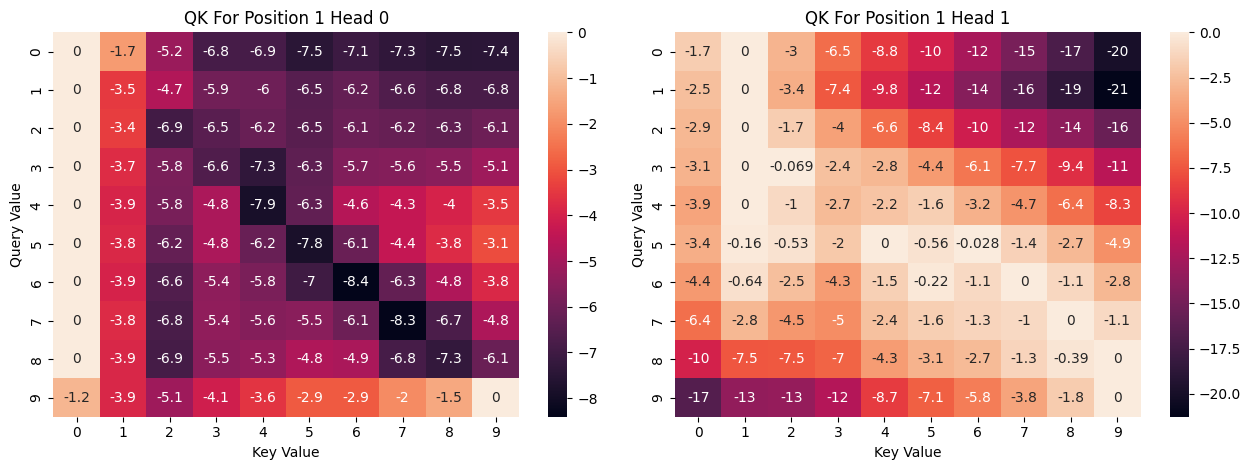

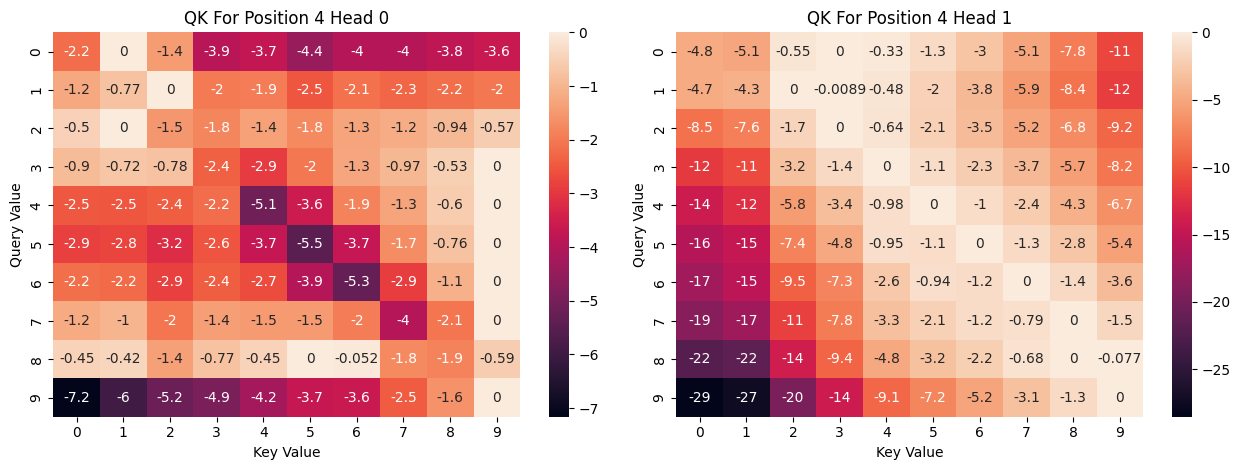

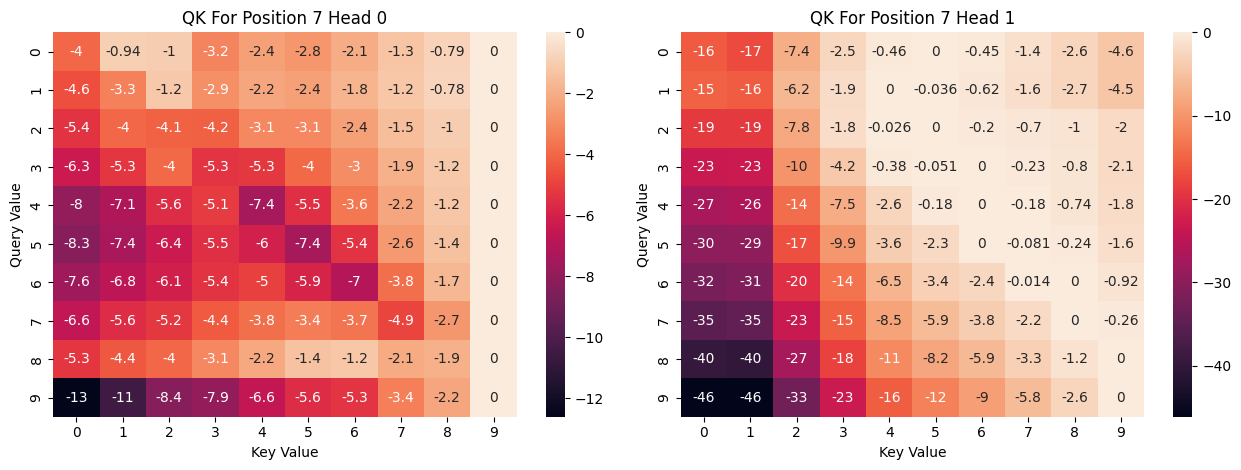

In [123]:
for pos in [1,4,7]:
    plot_qk_for_out(pos)

unsorted_sequence tensor([5, 5, 5, 8, 9, 9, 9, 9, 9, 9])
sorted_sequence tensor([5, 5, 5, 8, 9, 9, 9, 9, 9, 9])


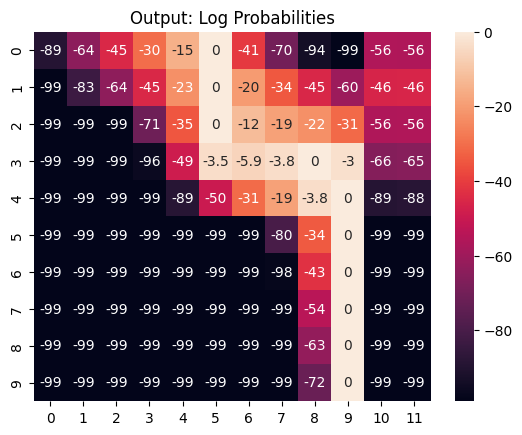

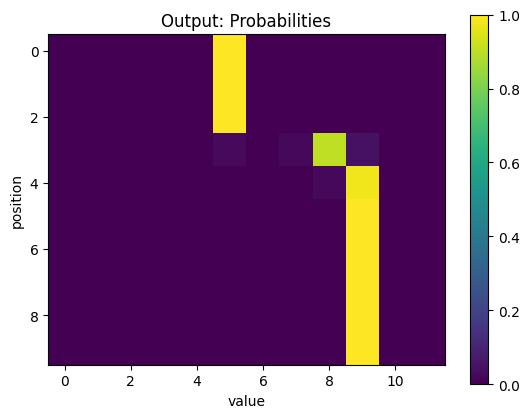

In [124]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,8]+[9]*6))


unsorted_sequence tensor([0, 0, 0, 0, 0, 0, 0, 3, 4, 4])
sorted_sequence tensor([0, 0, 0, 0, 0, 0, 0, 3, 4, 4])


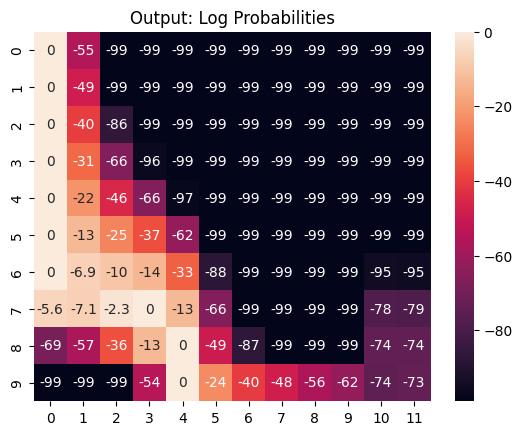

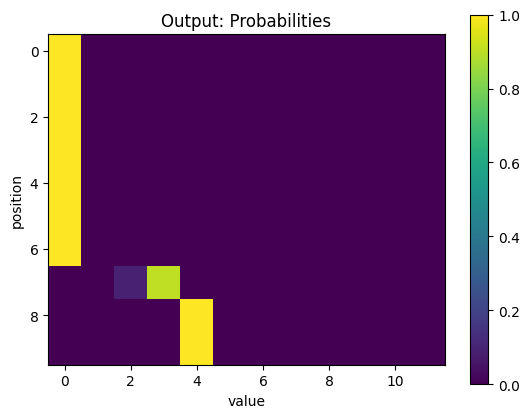

In [121]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[3]+[4,4]))

unsorted_sequence tensor([0, 0, 0, 5, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 0, 0, 5, 7, 7, 7, 7, 7, 7])


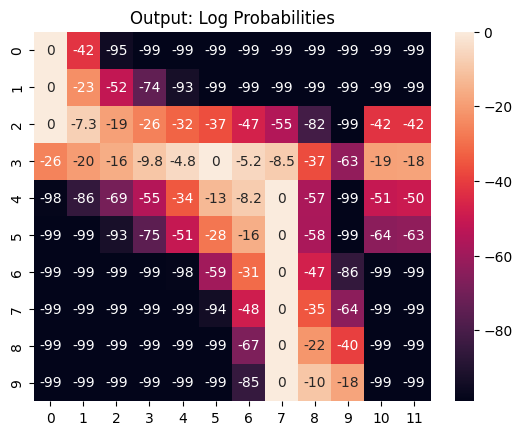

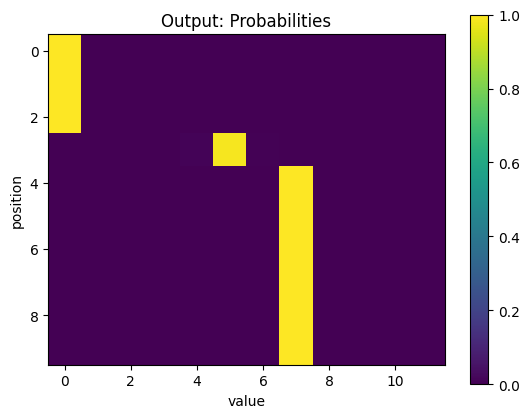

In [88]:
# QK for position 14
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 0, 5] + [7]*6))

pos = 2


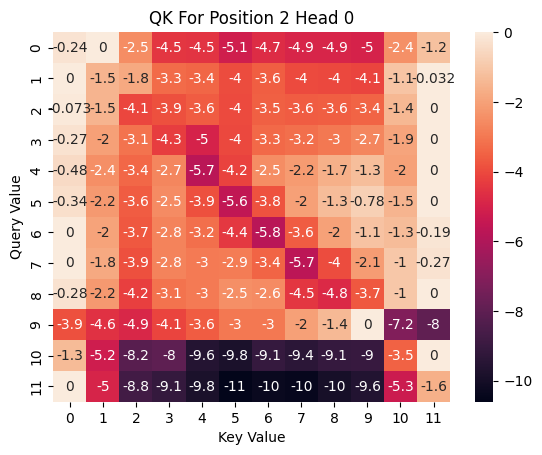

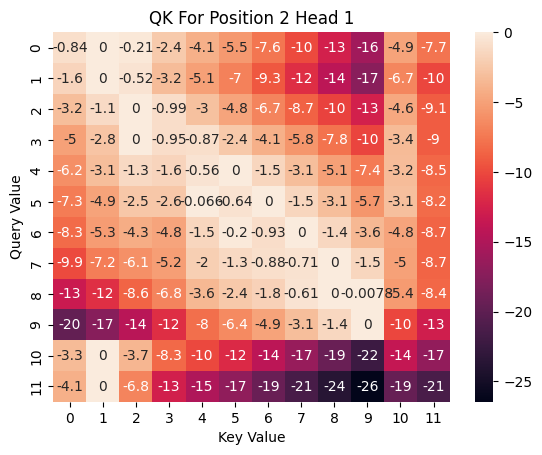

In [104]:
plot_qk_for_out(2)

pos = 1
torch.Size([12, 28])


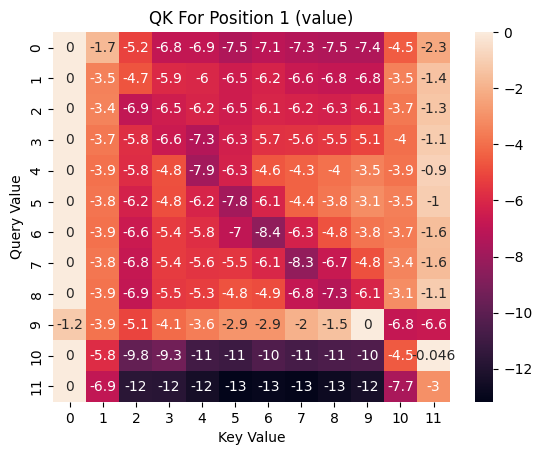

In [90]:
plot_qk_for_out(1)

unsorted_sequence tensor([0, 0, 6, 7, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 0, 6, 7, 7, 7, 7, 7, 7, 7])


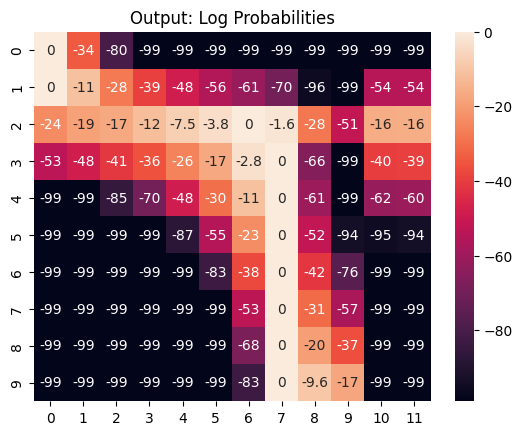

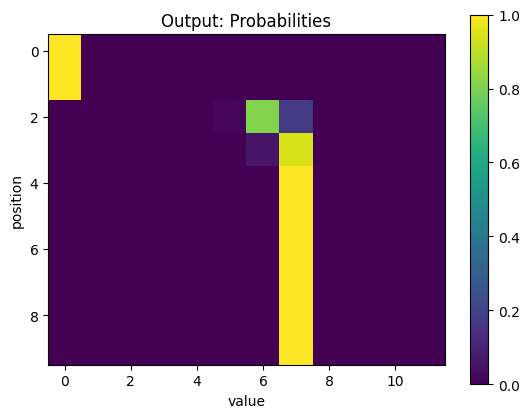

In [91]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 6] + [7]*7))

In [92]:
def max_dif(a: t.Tensor, b: t.Tensor):
    assert a.shape == b.shape, f"found different shapes {a.shape} {b.shape}"
    print("max_dif =", t.max(t.abs(a-b)))

unsorted_sequence tensor([0, 6, 7, 7, 7, 7, 7, 7, 7, 7])
sorted_sequence tensor([0, 6, 7, 7, 7, 7, 7, 7, 7, 7])


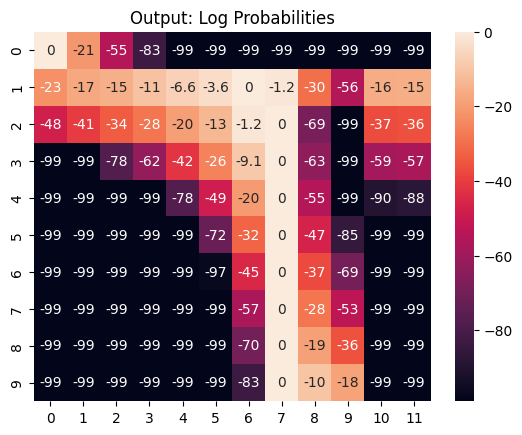

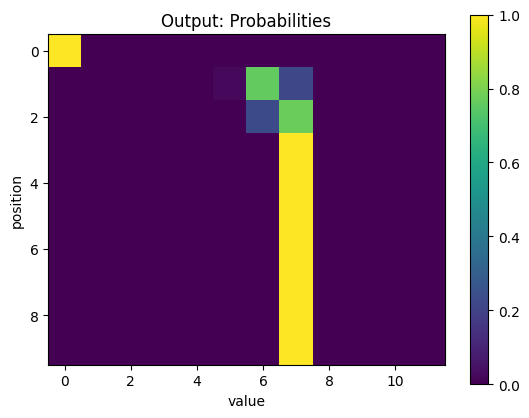

In [93]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 6] + [7]*8))

unsorted_sequence tensor([0, 5, 9, 9, 9, 9, 9, 9, 9, 9])
sorted_sequence tensor([0, 5, 9, 9, 9, 9, 9, 9, 9, 9])


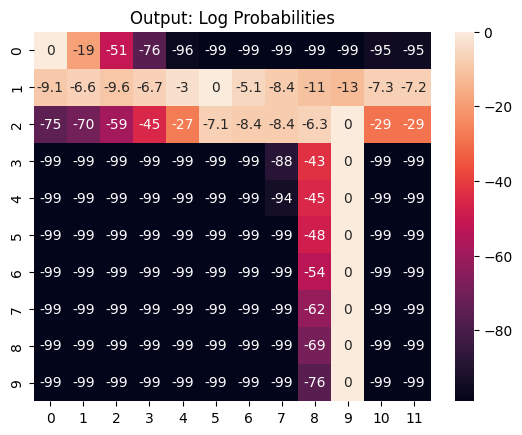

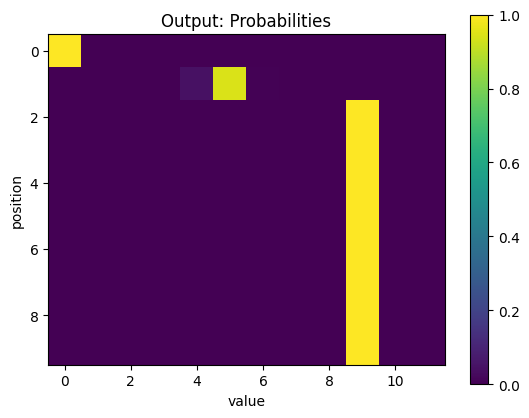

In [94]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 5] + [9]*8))

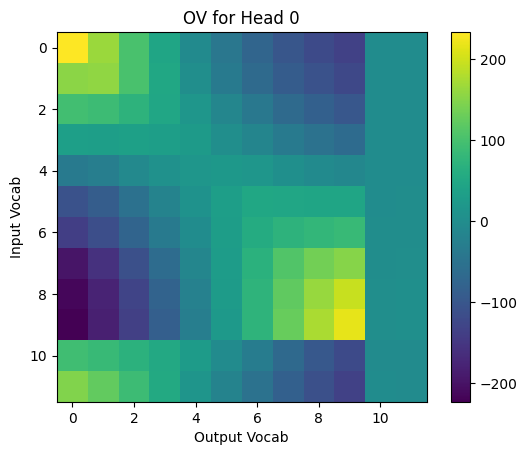

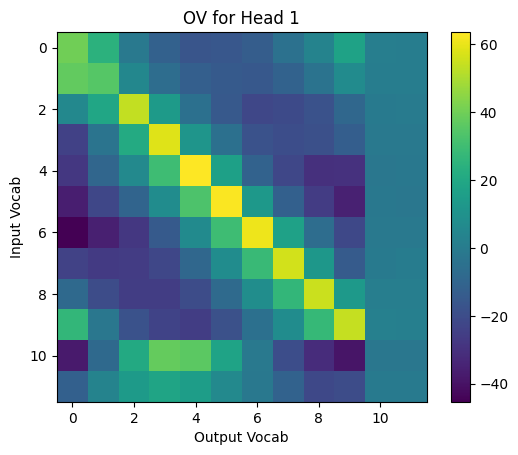

In [106]:
with t.inference_mode():
    for head in range(2):
        OV = model.W_E @ model.W_V[0, head] @ model.W_O[0, head] @ model.W_U

        plt.figure()
        plt.title(f"OV for Head {head}")
        plt.imshow(OV.cpu())
        plt.colorbar()
        plt.ylabel("Input Vocab")
        plt.xlabel("Output Vocab")

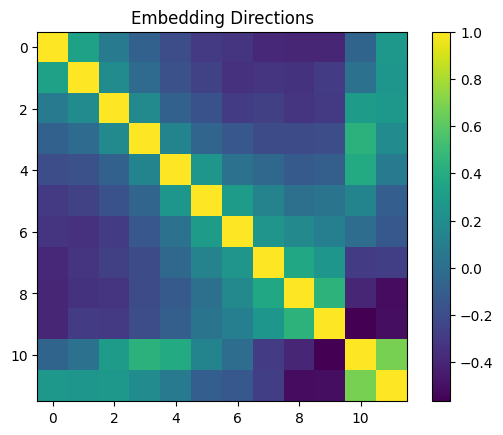

In [98]:
with t.inference_mode():
    plt.title("Embedding Directions")
    embedding_vectors = model.W_E.clone()
    embedding_vectors /= t.linalg.norm(embedding_vectors, dim=-1, keepdim=True)
    plt.imshow((embedding_vectors @ embedding_vectors.T).cpu())
    plt.colorbar()

## Hypothesis

1-head: The model is implementing something like the following function:

```py
def element_at_pos(s: set, prev_val: int, pos: int):
    if s.count_greater_than(prev_val) >= len(s) - pos: 
        # ^ note: the above inequality cannot be strict
        return s.get_min_greater_than(prev_val)
        # ^ this can easily be obtained assuming transformer only pays attention to tokens with value > prev_val
        # a token increases the logit corresponding to its value. tokens with lower values result in higher increases
    else:
        return prev_val
```

Equivalently:

```
out_val =
BIG * (# >= val) + val if val > prev_val
BIG * (len(s) - pos) + val if val <= prev_val
```

but the transformer looks like:

```
BIG * f(# >= val / (# >= prev_val + smth depending on pos and prev_val)) + val if val >= prev_val
+ BIG * f((smth depending on pos and prev_val) / (# >= prev_val + smth depending on pos and prev_val)) + val for val = prev_val
```

What we know:
 - Transformer filters out everything `< prev_val`.
 - Transformer does pay attention to things with value equal to `prev_val` (why?).

WRONG:

Actually, to predict the next token in the output sequence, we only need a linear layer taking as input:
 - sum of the embeddings for each value in the input sequence
 - embedding of the previous value in the output sequence
 - embedding of the current position

In [99]:
# from sklearn.decomposition import PCA
# pcaer = PCA(n_components=10)
# pcas=pcaer.fit_transform(model.W_E.T.detach().cpu().numpy())


# fig, ax = plt.subplots()
# z=pcas[:10,2]
# y=pcas[:10,1]
# ax.scatter(z, y)

# for i in range(len(z)):
#     ax.annotate(str(i), (z[i], y[i]))